In [32]:
# load and evaluate a saved model
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.preprocessing import  StandardScaler, LabelEncoder, OneHotEncoder, LabelBinarizer, MinMaxScaler
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score

from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform
import tensorflow as tf

from keras.models import Sequential,load_model
from keras.layers import Dense, LSTM, SimpleRNN, Dropout, GaussianNoise, Activation
from keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical 
from keras.wrappers.scikit_learn import KerasClassifier

from numpy import loadtxt

from matplotlib import pyplot as plt
%matplotlib inline

In [8]:
model = load_model('ANN Models/all_inputs_balanced_model.h5')
model.summary()

Model: "sequential_144"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_432 (Dense)            (None, 32)                864       
_________________________________________________________________
activation_432 (Activation)  (None, 32)                0         
_________________________________________________________________
dropout_288 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_433 (Dense)            (None, 24)                792       
_________________________________________________________________
activation_433 (Activation)  (None, 24)                0         
_________________________________________________________________
dropout_289 (Dropout)        (None, 24)                0         
_________________________________________________________________
dense_434 (Dense)            (None, 2)              

In [9]:
#data function for reading and processing the train and test sets
#necessary as an input for the optimisation algorithm
def data():
    #define input processing function
    def process_attributes(df, train, test):
        
        #define and fit the scaler to the full dataset
        cs = MinMaxScaler()
        cs.fit(df_inputs.select_dtypes(np.number))
        
        #scale the numerical input variables
        trainContinuous = cs.transform(train.select_dtypes(np.number))
        testContinuous = cs.transform(test.select_dtypes(np.number))
        
        if 'Gender' in df.columns:
            
            #uncomment the code below to accommodate for any categorical columns
            zipBinarizer = LabelBinarizer().fit(df["Gender"])
            trainCategorical = zipBinarizer.transform(train["Gender"])
            testCategorical = zipBinarizer.transform(test["Gender"])

            # construct our training and testing data points by concatenating
            # the categorical features with the continuous features
            trainX = np.hstack([trainContinuous, trainCategorical])
            testX = np.hstack([testContinuous, testCategorical])
            
        else:
            trainX=trainContinuous
            testX=testContinuous
        
        # return the concatenated training and testing data
        return (trainX, testX)
    
    #read the excel datasets
    df = pd.read_excel('Cleaned_Dataframe.xlsx')
    df.set_index('Sample',inplace=True)
    features=df.columns

    df_cancer = df.loc[df['Status'] == 'Cancer']
    df_control = df.loc[df['Status'] == 'Control']

    #randomly seelct 538 samples from the cancer population to create an equal sample size 
    df_cancer_small = df_cancer.sample(n=538, random_state = 100)

    df1 = pd.concat([df_cancer_small, df_control])
    #separate cancer markers and input data
    df_outputs= df1['Status']
    df_inputs = df1.drop(['Status'],axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(df_inputs, df_outputs, random_state=100, stratify=df_outputs, test_size=0.3)
    
    #process the input sets
    (X_train_sc, X_test_sc) = process_attributes(df_inputs, X_train, X_test)
    
    #encode the categorical output variables
    #encode categorical outputs
    lb = LabelBinarizer()
    lb.fit(y_train)
    train_outputs= lb.transform(y_train)
    test_outputs= lb.transform(y_test)

    Y_train = tf.keras.utils.to_categorical(train_outputs)
    Y_test = tf.keras.utils.to_categorical(test_outputs)

    return X_train_sc, Y_train, X_test_sc, Y_test, lb, features

In [10]:
#call in data function for test evaluation later
X_train, Y_train, X_test, Y_test, lb, features = data()
print('The model uses the following features:', features)

The model uses the following features: Index(['GP1', 'GP2', 'GP3', 'GP4', 'GP5', 'GP6', 'GP7', 'GP8', 'GP9', 'GP10',
       'GP11', 'GP12', 'GP13', 'GP14', 'GP15', 'GP16', 'GP17', 'GP18', 'GP19',
       'GP20', 'GP21', 'GP22', 'GP23', 'GP24', 'Gender', 'Age at sample',
       'Status'],
      dtype='object')


In [12]:
#Calculate the labels for the test set
predictions = model.predict(X_test)

In [15]:
#evaluate test performance of the model
print('Cancer is encoded by',lb.transform(['Cancer']), ', while Control is encoded by',lb.transform(['Control']))
print(confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(predictions, axis=1)))
print(classification_report(np.argmax(Y_test, axis=1), np.argmax(predictions, axis=1), target_names=lb.classes_))

Cancer is encoded by [[0]] , while Control is encoded by [[1]]
[[105  57]
 [ 18 143]]
              precision    recall  f1-score   support

      Cancer       0.85      0.65      0.74       162
     Control       0.71      0.89      0.79       161

    accuracy                           0.77       323
   macro avg       0.78      0.77      0.76       323
weighted avg       0.78      0.77      0.76       323



In [16]:
# keep probabilities for the positive outcome only
positive_prb = predictions[:, 1]

In [17]:
positive_prb

array([6.7783356e-01, 2.4089041e-01, 8.4759974e-01, 9.9866855e-01,
       1.9061211e-02, 7.8158528e-01, 4.9151981e-01, 3.5794454e-03,
       8.2893170e-02, 6.9497335e-01, 6.6504639e-01, 8.5934049e-01,
       8.3609301e-01, 8.2098603e-01, 3.9638267e-04, 5.7086078e-03,
       8.5920495e-01, 6.2036437e-01, 5.8467919e-09, 5.1199913e-01,
       4.4958014e-03, 6.0007813e-05, 8.7916368e-01, 7.4867165e-01,
       7.3491621e-01, 4.8363352e-05, 6.6880276e-03, 9.6875452e-02,
       2.4022576e-03, 6.3227832e-01, 1.7941023e-01, 1.3787109e-02,
       6.4670295e-01, 7.4334824e-01, 7.5498849e-01, 7.4211740e-01,
       7.6546258e-01, 3.3417079e-03, 7.5519741e-01, 7.6411653e-01,
       5.6990802e-01, 3.9059925e-01, 9.5225525e-01, 7.1177155e-01,
       2.0874235e-04, 7.0982361e-03, 8.4561521e-01, 6.8768188e-02,
       8.6423010e-01, 6.4226550e-01, 8.5086930e-01, 3.2357529e-02,
       2.0373531e-01, 9.5096785e-01, 7.9401833e-01, 8.5416055e-01,
       5.7459235e-01, 6.3490927e-01, 8.0206650e-01, 6.5264785e

In [20]:
np.argmax(Y_test, axis=1)

array([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,

In [25]:
lr_auc = roc_auc_score(np.argmax(Y_test, axis=1), positive_prb)
print(lr_auc)

0.8237098382025918


In [26]:
lr_fpr, lr_tpr, _ = roc_curve(np.argmax(Y_test, axis=1), positive_prb)

In [49]:
ns_probs = [0 for _ in range(len(np.argmax(Y_test, axis=1)))]
ns_fpr, ns_tpr, _ = roc_curve(np.argmax(Y_test, axis=1), ns_probs)

Text(0, 0.5, 'Sensitivity')

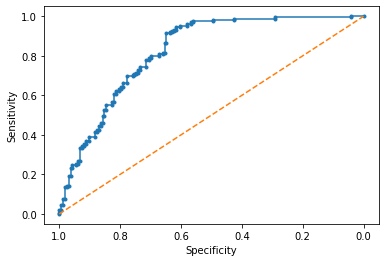

In [51]:
fig, axs = plt.subplots() 
axs.plot(1-lr_fpr, lr_tpr, marker='.', label='ANN')
axs.plot(1-ns_fpr, ns_tpr, linestyle='--', label='No Skill')
axs.invert_xaxis()
axs.set_xlabel("Specificity") 
axs.set_ylabel("Sensitivity") 